# Stock API
Using [Yahoo Finance API](https://python-yahoofinance.readthedocs.io/en/latest/api.html) to get stock information. yFinance is an open-source Python library which enable us to fetch any US stock data in a predefined time period

# Import Libraries

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
import math
from os import walk
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

import yfinance as yf
from arch import arch_model
from arch.__future__ import reindexing

Average volume greater than 1-2 million

# Data

In [4]:
path = "Sample Data/"
filenames = next(walk(path), (None, None, []))[2]
print("Number of Stocks:", len(filenames))

Number of Stocks: 43


In [5]:
tickerSymbols = [file.split("_", 1)[0] for file in filenames]
tickerSymbols[0:5]

['TSLA', 'AAPL', 'JNJ', 'JPM', 'AMZN']

In [6]:
index = 1
tickerSymbol = tickerSymbols[index]
tickerSymbol

'AAPL'

## Fetch stock data from yahoo finance

In [7]:
start = "2018-09-08"
end = "2021-01-29"
stock_data = yf.download(tickerSymbol, start=start, end=end)

[*********************100%***********************]  1 of 1 completed


In [8]:
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-09-10,55.237499,55.462502,54.117500,54.582500,52.880280,158066000
2018-09-11,54.502499,56.075001,54.139999,55.962502,54.217247,142996000
2018-09-12,56.235001,56.250000,54.959999,55.267502,53.543922,197114800
2018-09-13,55.880001,57.087502,55.642502,56.602501,54.837284,166825600
2018-09-14,56.437500,56.709999,55.630001,55.959999,54.214817,127997200


## Calculate Daily Returns

In [9]:
stock_data['Return'] = 100 * (stock_data['Close'].pct_change())

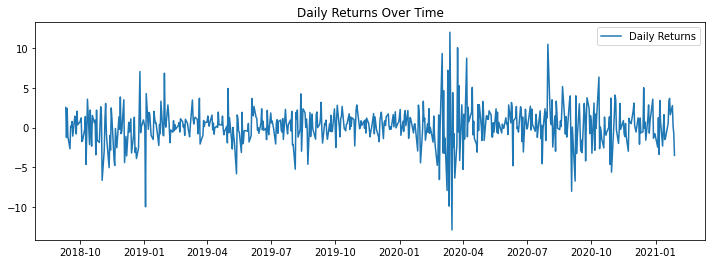

In [10]:
stock_data.dropna(inplace=True)

fig = plt.figure()
fig.set_figwidth(12)
plt.plot(stock_data['Return'], label = 'Daily Returns')
plt.legend(loc='upper right')
plt.title('Daily Returns Over Time')
plt.show()

## Calculate daily, monthly, and annual volatitily

In [11]:
daily_volatility = stock_data['Return'].std()
print('Daily volatility: ', '{:.2f}%'.format(daily_volatility))

monthly_volatility = math.sqrt(21) * daily_volatility
print ('Monthly volatility: ', '{:.2f}%'.format(monthly_volatility))

annual_volatility = math.sqrt(252) * daily_volatility
print ('Annual volatility: ', '{:.2f}%'.format(annual_volatility ))

Daily volatility:  2.39%
Monthly volatility:  10.94%
Annual volatility:  37.90%


## Predict Stock Volatilty using GARCH model
Generalized Auto Regressive Conditional Heteroskedasticity

In [12]:
garch_model = arch_model(stock_data['Return'], p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')

gm_result = garch_model.fit(disp='off')
print(gm_result.params)

print('\n')

gm_forecast = gm_result.forecast(horizon = 5)
print(gm_forecast.variance[-1:])

mu          0.318366
omega       0.184209
alpha[1]    0.167795
beta[1]     0.811868
Name: params, dtype: float64


                 h.1       h.2       h.3       h.4       h.5
Date                                                        
2021-01-28  5.942946  6.006293  6.068352  6.129149  6.188709


# Rolling forecast using GARCH model

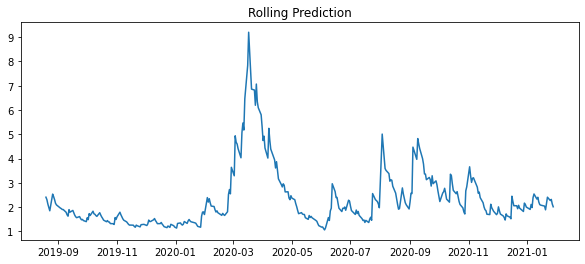

In [18]:
rolling_predictions = []
test_size = 365

for i in range(test_size):
    train = stock_data['Return'][:-(test_size-i)]
    model = arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
    
rolling_predictions = pd.Series(rolling_predictions, index=stock_data['Return'].index[-365:])

plt.figure(figsize=(10,4))
plt.plot(rolling_predictions)
plt.title('Rolling Prediction')
plt.show()

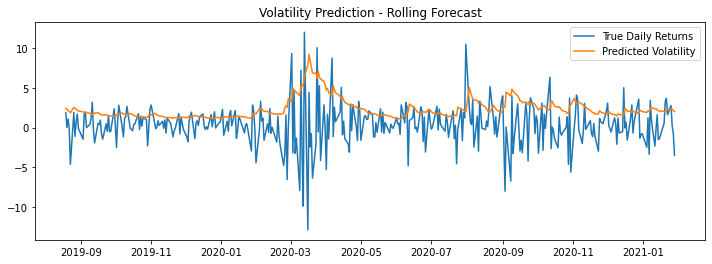

In [19]:
plt.figure(figsize=(12,4))
plt.plot(stock_data['Return'][-365:])
plt.plot(rolling_predictions)
plt.title('Volatility Prediction - Rolling Forecast')
plt.legend(['True Daily Returns', 'Predicted Volatility'])
plt.show()